<a href="https://colab.research.google.com/github/machio1985/Python_100_knock/blob/main/Python100pon_chapter4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
uselog = pd.read_csv('use_log.csv')
print(len(uselog))
uselog.isnull().sum()

197428


log_id         0
customer_id    0
usedate        0
dtype: int64

In [9]:
customer = pd.read_csv("customer_join.csv")
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

# ノック32 クラスタリング

In [14]:
customer_clustering = customer[["mean","median","max","min","membership_period"]]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [19]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)
kmeans = KMeans(n_clusters=4,random_state=0)
clusters=kmeans.fit(customer_clustering_sc)
customer_clustering["cluster"] = clusters.labels_
print(customer_clustering["cluster"].unique())
customer_clustering.head()

[2 0 3 1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,2
1,5.083333,5.0,7,3,47,2
2,4.583333,5.0,6,3,47,2
3,4.833333,4.5,7,2,47,2
4,3.916667,4.0,6,1,47,2


# ノック33 分析


In [22]:
customer_clustering.columns = ["月内平均値","月内中央値","月内最大値","月内最小値","会員期間","cluster"]
customer_clustering.groupby("cluster").count()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,763,763,763,763,763
1,846,846,846,846,846
2,1249,1249,1249,1249,1249
3,1334,1334,1334,1334,1334


In [23]:
customer_clustering.groupby("cluster").mean()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,3.054713,2.888598,4.756225,1.653997,9.263434
1,8.054608,8.039598,10.009456,6.160757,7.072104
2,4.677494,4.671337,7.232986,2.153723,36.915933
3,5.524239,5.375187,8.745877,2.687406,14.843328


In [24]:
from sklearn.decomposition import PCA
X  = customer_clustering_sc
pca = PCA(n_components = 2)
pca.fit(X)
x_pca =pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df["cluster"] = customer_clustering["cluster"]

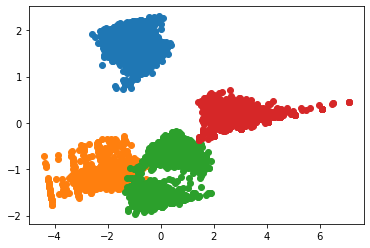

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in customer_clustering["cluster"].unique():
   tmp = pca_df.loc[pca_df["cluster"]==i]
   plt.scatter(tmp[0],tmp[1])

# ノック35 退会顧客傾向

In [28]:
customer_clustering = pd.concat([customer_clustering,customer],axis=1)
customer_clustering.groupby(["cluster","is_deleted"],as_index=False).count()[["cluster","is_deleted","customer_id"]]

,cluster,is_deleted,customer_id
0,0,1,763
1,1,0,827
2,1,1,19
3,2,0,1230
4,2,1,19
5,3,0,785
6,3,1,549


In [29]:
customer_clustering.groupby(["cluster","routine_flg"],as_index=False).count()[["cluster","routine_flg","customer_id"]]

,cluster,routine_flg,customer_id
0,0,0,497
1,0,1,266
2,1,0,52
3,1,1,794
4,2,0,2
5,2,1,1247
6,3,0,228
7,3,1,1106


# ノック36 利用回数予測

In [37]:
uselog["usedate"] = pd.to_datetime(uselog["usedate"])
uselog["年月"] = uselog["usedate"].dt.strftime("%Y%m")
uselog_months = uselog.groupby(["年月","customer_id"],as_index=False).count()
uselog_months.rename(columns={"log_id":"count"},inplace=True)
del uselog_months["usedate"]
uselog_months.head()

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [62]:
year_months = list(uselog_months["年月"].unique())
predict_data = pd.DataFrame()
for i in range(6, len(year_months)):
  tmp = uselog_months.loc[uselog_months["年月"]==year_months[i]]
  tmp.rename(columns={"count":"count_pred"},inplace=True)
  for j in range(1,7):
    tmp_before = uselog_months.loc[uselog_months["年月"]==year_months[i-j]]
    del tmp_before["年月"]
    tmp_before.rename(columns={"count":"count_{}".format(j-1)},inplace=True)
    tmp = pd.merge(tmp , tmp_before , on ="customer_id",how ="left")
    predict_data = pd.concat([predict_data,tmp],ignore_index=True)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [63]:
    predict_data.tail()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
109855,201903,TS995853,8,11.0,NaN,NaN,NaN,NaN,NaN
109856,201903,TS998593,8,7.0,8.0,7.0,9.0,9.0,9.0
109857,201903,TS999079,3,2.0,6.0,9.0,6.0,6.0,4.0
109858,201903,TS999231,6,6.0,3.0,8.0,5.0,5.0,4.0
109859,201903,TS999855,4,4.0,7.0,5.0,4.0,4.0,5.0


In [64]:
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop=True)
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


# ノック37 特徴量の追加


In [65]:
predict_data = pd.merge(predict_data,customer[["customer_id","start_date"]],on = "customer_id",how = "left")
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [67]:
predict_data["now_date"]  = pd.to_datetime(predict_data["年月"],format = "%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])
from dateutil.relativedelta import relativedelta
predict_data["period"] = None
for i in range(len(predict_data)):
  delta = relativedelta(predict_data["now_date"][i],predict_data["start_date"][i])
  predict_data["period"][i] = delta.years*12 + delta.months
predict_data.head()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


# ノック38 予測モデル

In [74]:
predict_data = predict_data.loc[predict_data["start_date"]>pd.to_datetime("20180401")]
from sklearn import linear_model
import sklearn.model_selection
model = linear_model.LinearRegression()
X = predict_data[["count_0","count_1","count_2","count_3","count_4","count_5","period"]]
y = predict_data["count_pred"]
X_train , X_test,y_train,y_test = sklearn.model_selection.train_test_split(X,y)
model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [75]:
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))

0.5964916051739438
0.6417167457653463


#ノック39 変数重要度

In [80]:
coef = pd.DataFrame({"feature_names":X.columns,
                     "coefficient":model.coef_})
coef

,feature_names,coefficient
0,count_0,0.326698
1,count_1,0.174393
2,count_2,0.176799
3,count_3,0.186912
4,count_4,0.083659
5,count_5,0.052468
6,period,0.078944


# ノック40 来月予測

In [81]:
x1 = [3,4,4,6,8,7,8]
x2 = [2,2,3,3,4,6,8]
x_pred = [x1,x2]
model.predict(x_pred)

array([3.87329198, 2.07316987])

In [82]:
uselog_months.to_csv("use_log_months.csv",index=False)